In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import sklearn.metrics as metric
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import xgboost as xg
import lightgbm as lgbm

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

In [2]:
data = pd.read_csv('in-vehicle-coupon-recommendation.csv')

In [5]:
data.describe()

,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
count,12684.000000,12684.000000,12684.0,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000
mean,63.301798,0.414144,1.0,0.561495,0.119126,0.214759,0.785241,0.568433
std,19.154486,0.492593,0.0,0.496224,0.323950,0.410671,0.410671,0.495314
min,30.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
50%,80.000000,0.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
75%,80.000000,1.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
max,80.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
data.shape

(12684, 26)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

### Checking the Null values in all the columns of the dataset

In [8]:
data.isnull().sum().sort_values(ascending=False)

car                     12576
CoffeeHouse               217
Restaurant20To50          189
CarryAway                 151
RestaurantLessThan20      130
Bar                       107
destination                 0
passanger                   0
direction_opp               0
direction_same              0
toCoupon_GEQ25min           0
toCoupon_GEQ15min           0
toCoupon_GEQ5min            0
income                      0
occupation                  0
education                   0
has_children                0
maritalStatus               0
age                         0
gender                      0
expiration                  0
coupon                      0
time                        0
temperature                 0
weather                     0
Y                           0
dtype: int64

## Notes:
### Above data has different columns with NaN values, and among them 'car' column has the highest count.

In [9]:
# from the above info we can clearly observe that the 'car' column is not useful as it has 99.14% of the missing value
# removing the column 'car'

data.drop(columns=['car'], inplace=True)

In [10]:
data.corr()

,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
temperature,1.000000,-0.019716,NaN,-0.155332,-0.216254,0.097085,-0.097085,0.061240
has_children,-0.019716,1.000000,NaN,0.078211,-0.013722,-0.031620,0.031620,-0.045557
toCoupon_GEQ5min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
toCoupon_GEQ15min,-0.155332,0.078211,NaN,1.000000,0.324984,-0.303533,0.303533,-0.081602
toCoupon_GEQ25min,-0.216254,-0.013722,NaN,0.324984,1.000000,-0.192319,0.192319,-0.103633
direction_same,0.097085,-0.031620,NaN,-0.303533,-0.192319,1.000000,-1.000000,0.014570
direction_opp,-0.097085,0.031620,NaN,0.303533,0.192319,-1.000000,1.000000,-0.014570
Y,0.061240,-0.045557,NaN,-0.081602,-0.103633,0.014570,-0.014570,1.000000


In [11]:
data.select_dtypes(include=['object'])

,destination,passanger,weather,time,coupon,expiration,gender,age,maritalStatus,education,occupation,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50
0,No Urgent Place,Alone,Sunny,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,NaN,4~8,1~3
1,No Urgent Place,Friend(s),Sunny,10AM,Coffee House,2h,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,NaN,4~8,1~3
2,No Urgent Place,Friend(s),Sunny,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,NaN,4~8,1~3
3,No Urgent Place,Friend(s),Sunny,2PM,Coffee House,2h,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,NaN,4~8,1~3
4,No Urgent Place,Friend(s),Sunny,2PM,Coffee House,1d,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,NaN,4~8,1~3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,Home,Partner,Rainy,6PM,Carry out & Take away,1d,Male,26,Single,Bachelors degree,Sales & Related,$75000 - $87499,never,never,1~3,4~8,1~3
12680,Work,Alone,Rainy,7AM,Carry out & Take away,1d,Male,26,Single,Bachelors degree,Sales & Related,$75000 - $87499,never,never,1~3,4~8,1~3
12681,Work,Alone,Snowy,7AM,Coffee House,1d,Male,26,Single,Bachelors degree,Sales & Related,$75000 - $87499,never,never,1~3,4~8,1~3
12682,Work,Alone,Snowy,7AM,Bar,1d,Male,26,Single,Bachelors degree,Sales & Related,$75000 - $87499,never,never,1~3,4~8,1~3


In [12]:
# changing the data type of the categorical columns to category from object dtype

data_object = data.select_dtypes(include=['object']).copy()

for col in data_object.columns:
    data[col]=data[col].astype('category')
    
data.dtypes


destination             category
passanger               category
weather                 category
temperature                int64
time                    category
coupon                  category
expiration              category
gender                  category
age                     category
maritalStatus           category
has_children               int64
education               category
occupation              category
income                  category
Bar                     category
CoffeeHouse             category
CarryAway               category
RestaurantLessThan20    category
Restaurant20To50        category
toCoupon_GEQ5min           int64
toCoupon_GEQ15min          int64
toCoupon_GEQ25min          int64
direction_same             int64
direction_opp              int64
Y                          int64
dtype: object

In [13]:
data.select_dtypes(include=['int64']).nunique()

temperature          3
has_children         2
toCoupon_GEQ5min     1
toCoupon_GEQ15min    2
toCoupon_GEQ25min    2
direction_same       2
direction_opp        2
Y                    2
dtype: int64

### It is clearly evident that the column 'toCoupon_GEQ5min' has only one unique value which will not be of any help for the model.

In [14]:
# dropping toCoupon_GEQ5min column from the data
data.drop(columns=['toCoupon_GEQ5min'], inplace=True)

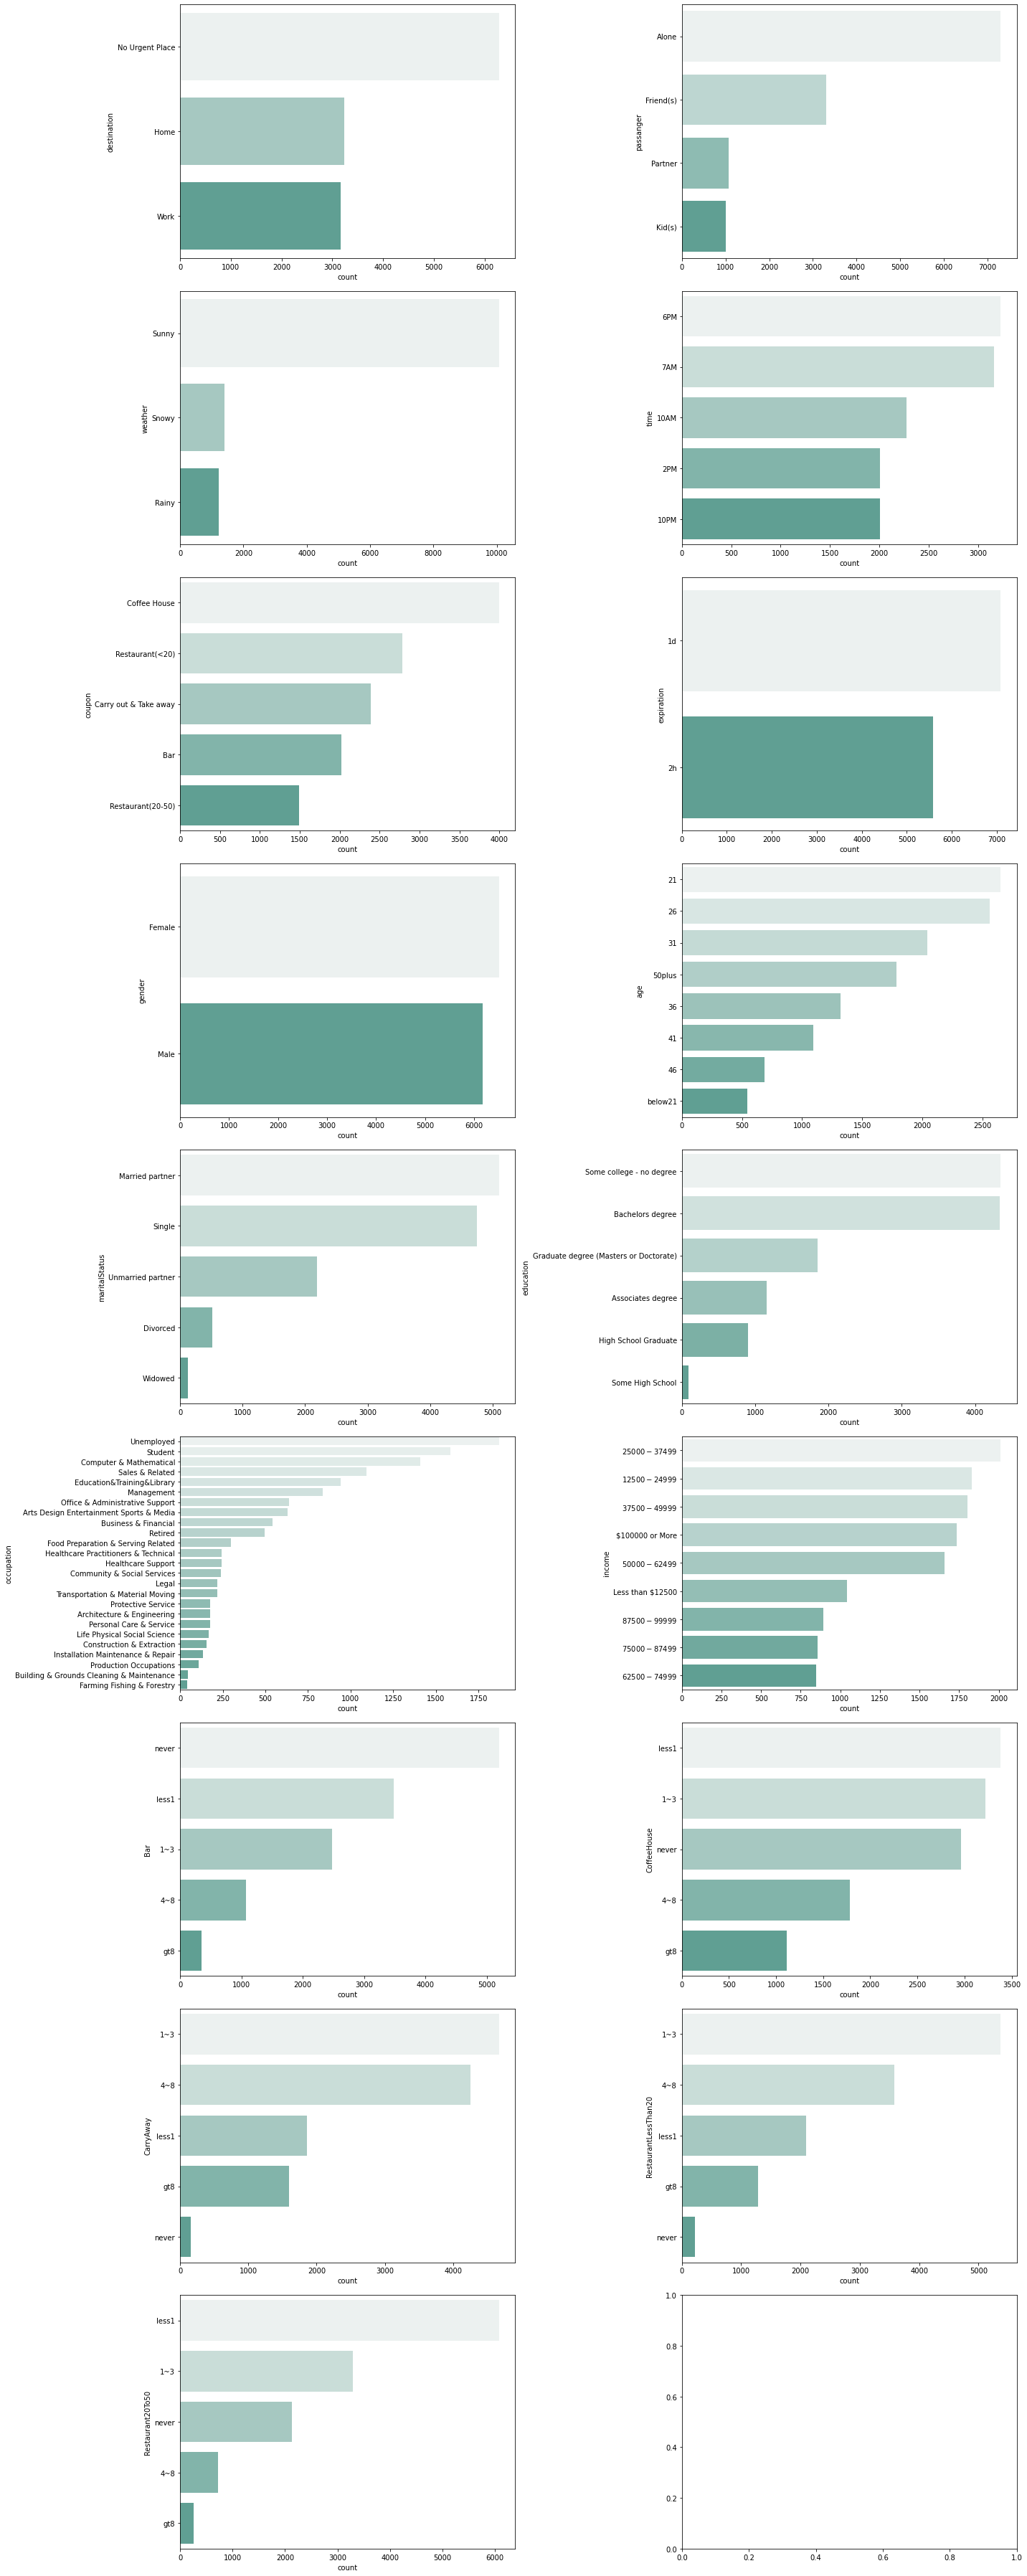

In [15]:
# code used from Kaggle to plot the categorical variable along with their count
fig, axes = plt.subplots(9, 2, figsize=(20,50))
axes = axes.flatten()

for ax, col in zip(axes, data.select_dtypes('category').columns):
    sns.countplot(y=col, data=data, ax=ax, 
                  palette="light:#5A9", order=data[col].value_counts().index);

plt.tight_layout()
plt.show()

In [16]:
data_object.columns

Index(['destination', 'passanger', 'weather', 'time', 'coupon', 'expiration',
       'gender', 'age', 'maritalStatus', 'education', 'occupation', 'income',
       'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20',
       'Restaurant20To50'],
      dtype='object')

In [17]:
data.isnull().sum().sort_values(ascending=False)

CoffeeHouse             217
Restaurant20To50        189
CarryAway               151
RestaurantLessThan20    130
Bar                     107
destination               0
passanger                 0
direction_opp             0
direction_same            0
toCoupon_GEQ25min         0
toCoupon_GEQ15min         0
income                    0
occupation                0
education                 0
has_children              0
maritalStatus             0
age                       0
gender                    0
expiration                0
coupon                    0
time                      0
temperature               0
weather                   0
Y                         0
dtype: int64

In [18]:
category_mapping = {'less1':0,'1~3':1,'never':2,'4~8':3,'gt8':4}

data['Bar'] = data['Bar'].map(category_mapping)

data['CoffeeHouse'] = data['CoffeeHouse'].map(category_mapping)

data['CarryAway'] = data['CarryAway'].map(category_mapping)

data['RestaurantLessThan20'] = data['RestaurantLessThan20'].map(category_mapping)

data['Restaurant20To50'] = data['Restaurant20To50'].map(category_mapping)

In [19]:
iterative_imp = IterativeImputer(estimator=RandomForestClassifier(), 
                               initial_strategy='most_frequent',
                               max_iter=10, random_state=42)
categorical_data = data[['Bar','CoffeeHouse','Restaurant20To50','CarryAway','RestaurantLessThan20']]

categorical_data = iterative_imp.fit_transform(categorical_data)

data[['Bar','CoffeeHouse','Restaurant20To50','CarryAway','RestaurantLessThan20']]= categorical_data

/usr/lib/python3/dist-packages/sklearn/impute/_base.py:42: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/usr/lib/python3/dist-packages/sklearn/impute/_base.py:42: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/usr

In [20]:
data.isnull().sum().sort_values(ascending=False)

destination             0
passanger               0
direction_opp           0
direction_same          0
toCoupon_GEQ25min       0
toCoupon_GEQ15min       0
Restaurant20To50        0
RestaurantLessThan20    0
CarryAway               0
CoffeeHouse             0
Bar                     0
income                  0
occupation              0
education               0
has_children            0
maritalStatus           0
age                     0
gender                  0
expiration              0
coupon                  0
time                    0
temperature             0
weather                 0
Y                       0
dtype: int64

In [21]:
high_cardinality = []
for each in data_object.columns:
    if len(data[each].unique())>=3:
        high_cardinality.append(each)

low_cardinality_columns = list(set(data_object.columns) - set(high_cardinality))

# low_cardinality_columns = list(set(low_cardinality_columns) - set(['Bar','CoffeeHouse','Restaurant20To50','CarryAway','RestaurantLessThan20']))

label_enc = LabelEncoder()
for each in low_cardinality_columns:
    data[each] = label_enc.fit_transform(data[each])

data = pd.get_dummies(data,columns=high_cardinality, drop_first=True, prefix=high_cardinality)

In [22]:
low_cardinality_columns

['expiration', 'gender']

<AxesSubplot:>

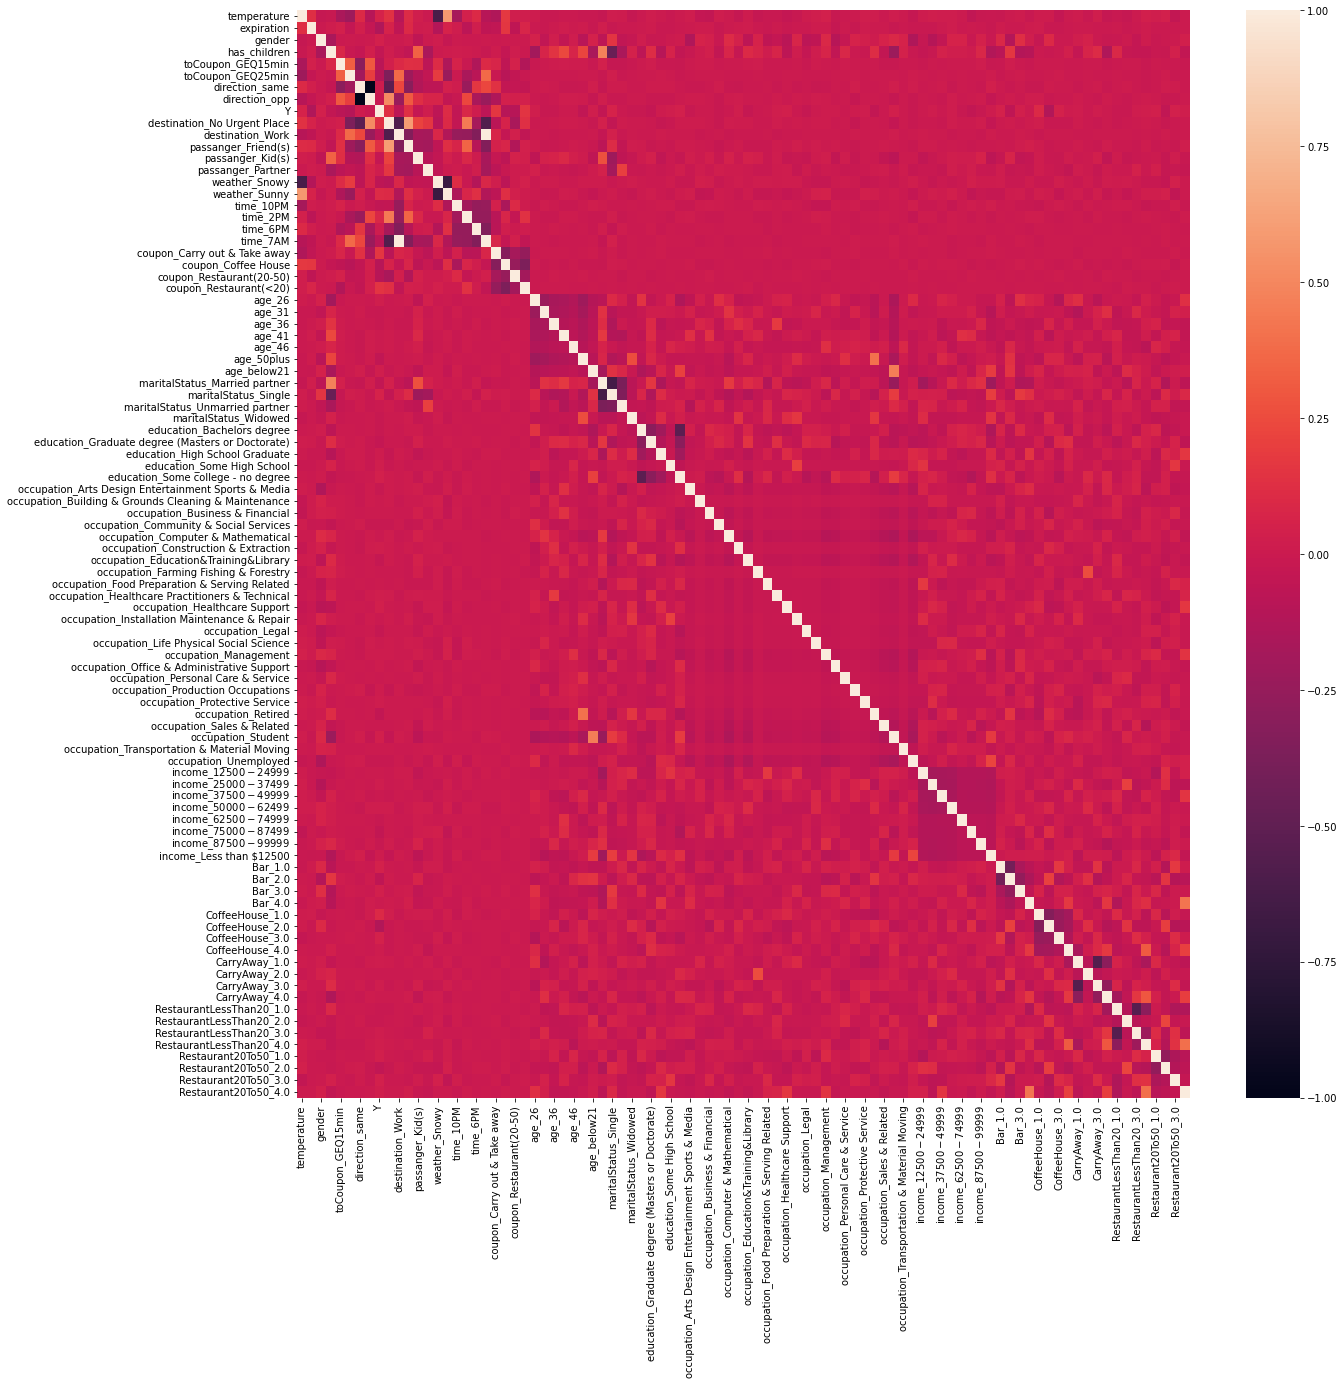

In [23]:
plt.figure(figsize=(20,20))
sns.heatmap(data.corr())

In [24]:
data.corr()

,temperature,expiration,gender,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y,destination_No Urgent Place,...,CarryAway_3.0,CarryAway_4.0,RestaurantLessThan20_1.0,RestaurantLessThan20_2.0,RestaurantLessThan20_3.0,RestaurantLessThan20_4.0,Restaurant20To50_1.0,Restaurant20To50_2.0,Restaurant20To50_3.0,Restaurant20To50_4.0
temperature,1.000000,0.124090,-0.025504,-0.019716,-0.155332,-0.216254,0.097085,-0.097085,0.061240,0.135549,...,0.029757,-0.025867,-0.012630,-0.029996,0.005221,0.032156,0.024766,0.041733,-0.041033,0.000240
expiration,0.124090,1.000000,-0.001264,0.016020,0.042740,-0.032977,0.033584,-0.033584,-0.129920,0.059236,...,-0.002439,-0.000418,0.006265,-0.009741,-0.002218,0.010199,-0.001349,-0.007424,-0.000008,0.002880
gender,-0.025504,-0.001264,1.000000,-0.159956,-0.007028,0.002743,-0.004496,0.004496,0.043969,0.006377,...,-0.006997,-0.018445,-0.010265,0.003542,-0.037431,0.014962,-0.009056,-0.007660,0.005900,0.033719
has_children,-0.019716,0.016020,-0.159956,1.000000,0.078211,-0.013722,-0.031620,0.031620,-0.045557,0.023348,...,0.104755,-0.126096,0.086934,-0.030787,-0.037534,-0.035633,-0.015532,-0.022884,0.043699,-0.042978
toCoupon_GEQ15min,-0.155332,0.042740,-0.007028,0.078211,1.000000,0.324984,-0.303533,0.303533,-0.081602,0.036904,...,0.000942,-0.008639,-0.002530,0.001790,0.000879,-0.008699,0.004597,-0.001144,-0.006673,-0.011391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RestaurantLessThan20_4.0,0.032156,0.010199,0.014962,-0.035633,-0.008699,-0.008128,-0.008249,0.008249,0.026674,0.012269,...,0.030613,0.292844,-0.291988,-0.044607,-0.211446,1.000000,0.057047,-0.106130,0.137326,0.393968
Restaurant20To50_1.0,0.024766,-0.001349,-0.009056,-0.015532,0.004597,-0.002735,-0.006376,0.006376,0.031907,0.006225,...,-0.038862,0.045336,0.004089,-0.018000,0.104396,0.057047,1.000000,-0.267958,-0.146031,-0.086281
Restaurant20To50_2.0,0.041733,-0.007424,-0.007660,-0.022884,-0.001144,0.011610,0.020208,-0.020208,-0.047733,-0.022645,...,-0.044898,-0.046332,-0.047577,0.222704,-0.090189,-0.106130,-0.267958,1.000000,-0.111729,-0.066014
Restaurant20To50_3.0,-0.041033,-0.000008,0.005900,0.043699,-0.006673,-0.008082,0.012097,-0.012097,0.043238,-0.001094,...,0.102044,-0.004589,-0.139297,-0.032784,0.128735,0.137326,-0.146031,-0.111729,1.000000,-0.035976


In [25]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['Y']), data['Y'], test_size=0.25, random_state=42)

In [82]:
lr = LogisticRegression(solver='newton-cg', penalty='l2',C=.075)
lr.fit(X_train,y_train)
lr_predictions = lr.predict(X_test)

In [83]:
print(metric.classification_report(y_test,lr_predictions))

              precision    recall  f1-score   support

           0       0.68      0.56      0.61      1387
           1       0.70      0.79      0.74      1784

    accuracy                           0.69      3171
   macro avg       0.69      0.68      0.68      3171
weighted avg       0.69      0.69      0.69      3171

